In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

In [2]:
from cv2 import CascadeClassifier

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

In [43]:
def mask_on(face, mask_template=None):
    
    color = ('r','g','b')
    threshold = 0.8
    max_index = np.empty((3))
    
    for i, col in enumerate(color):
        hist, bins = np.histogram(face[face.shape[0]//2:, :, i].ravel(), 256, [0, 256])
        max_index[i] = np.argmax(hist)
        
    if np.all(max_index > 220):
        #a white or a light blue mask found
        return True
    
    while np.any(mask_template != None):
        if face.shape[0] < mask_template.shape[0] or \
            face.shape[1] < mask_template.shape[1]:
            #template bigger than the face found
            break
        
        match = cv2.matchTemplate(face[:,:,-1], mask_template[:,:,-1],cv2.TM_CCORR_NORMED)
        loc = np.where(match >= threshold)
        if loc:
            #template mask matched(in case a good template exists)
            return True
        break

    if np.all(max_index < 30):
        #natural dark pictures w\o masks
        return False
        
    mouth = mouth_cascade.detectMultiScale(face, 1.3, minNeighbors=20)
    if len(mouth) == 0: 
        #could not find a mouth
        return True
    
    #found a mouth and other cases didn't match
    return False

def detect_faces(frame, mask_template=None, draw_faces=False):
    #working with a grayscale picture
    frame_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #search for faces (with and without masks)
    faces = face_cascade.detectMultiScale(frame_g, scaleFactor=1.1, minNeighbors=5, minSize=(25, 25))
    
    masked = []
    not_masked = []
    fig = plt.figure()
    
    for i, (x, y, w, h) in enumerate(faces):
        #crop a face
        face = frame[y:y+h, x:x+w, :]
        
        if len(eye_cascade.detectMultiScale(face)) > 0:
            #eyes detection double checks a face
            
            if mask_on(face, mask_template):
                masked.append((x, y, w, h))
            else:
                not_masked.append((x, y, w, h))
                
    return masked, not_masked

def mask_recognition(frame, mask_template=None, draw_faces=False):
    masked, not_masked = detect_faces(frame, mask_template, draw_faces)
    
    #drawing rectangles of faces: with masks in green, without in red
    if masked != None:
        for (x, y, w, h) in masked:
            frame = cv2.rectangle(frame, (x, y), (x+w, y+h),  (0, 205, 0), 4)
            
    if not_masked != None:
        for (x, y, w, h) in not_masked:
            frame = cv2.rectangle(frame, (x, y), (x+w, y+h),  (205, 0, 0), 4)
    
    plt.imshow(frame)
    return 

In [44]:
from pathlib import Path

TEST_DIR = Path('./test')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

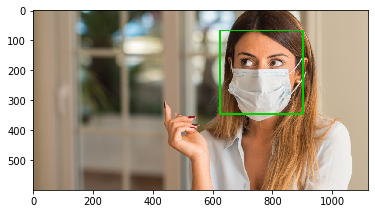

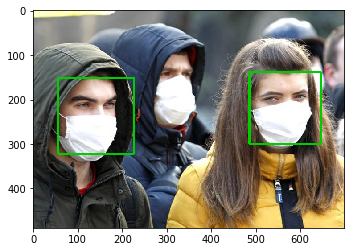

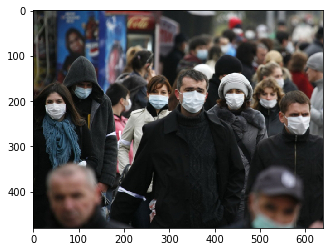

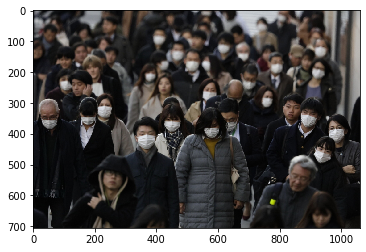

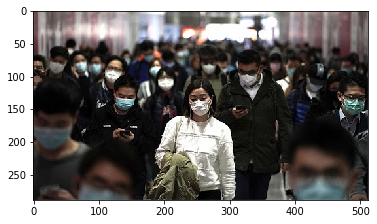

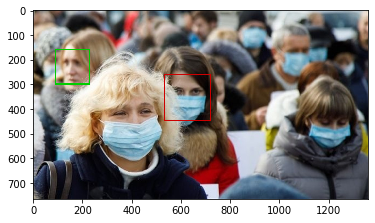

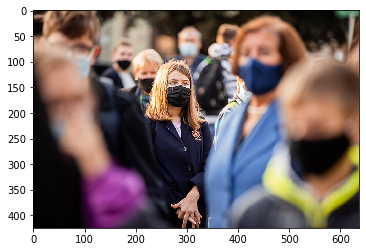

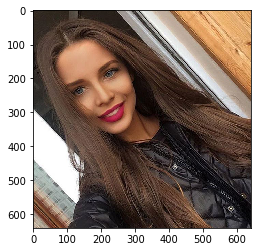

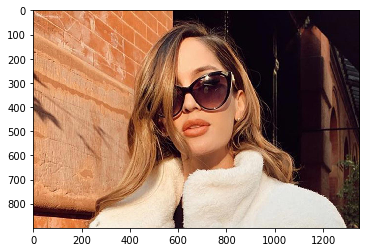

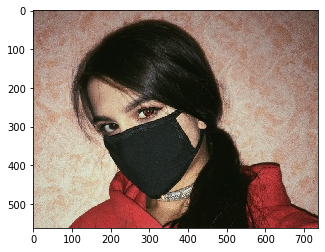

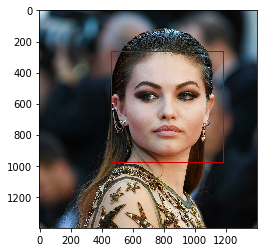

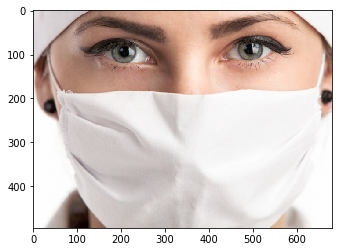

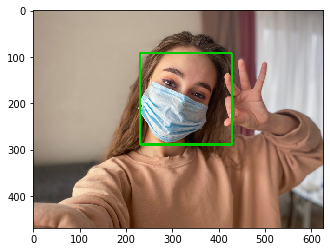

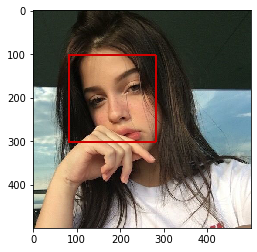

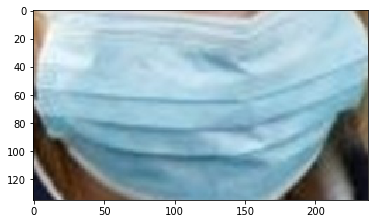

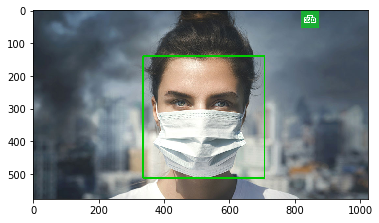

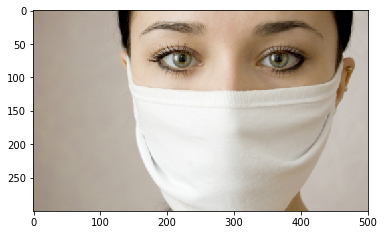

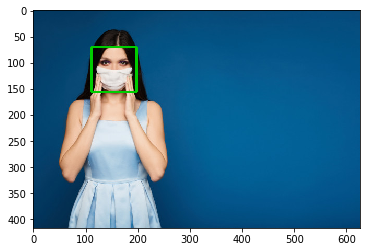

In [45]:
for path in test_files:
    img = Image.open(path)
    img.load()
    img = np.asarray(img)

    mask_recognition(img, None, True)